[View in Colaboratory](https://colab.research.google.com/github/gauravbansal98/Sentiment-classification-on-news-of-disaster-on-social-media-02-06-2018/blob/master/Using_bidirectional_dynamic_rnn_and_word_embeddings_accuray_around_79.ipynb)

In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib as plt
import random
import time
from collections import Counter
import keras
from keras.preprocessing.sequence import pad_sequences

import nltk
nltk.download()

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer

import os
os.chdir('drive/disasters on social media')

lemmatizer = WordNetLemmatizer()
stop_words = stopwords.words('english')
print(stop_words)

In [0]:
import re
import codecs
  

In [6]:
questions = pd.read_csv('socialmedia-disaster-tweets-DFE.csv', encoding = 'latin-1')
questions = questions[['choose_one', 'text']]
questions.head()


,choose_one,text
0,Relevant,Just happened a terrible car crash
1,Relevant,Our Deeds are the Reason of this #earthquake M...
2,Relevant,"Heard about #earthquake is different cities, s..."
3,Relevant,"there is a forest fire at spot pond, geese are..."
4,Relevant,Forest fire near La Ronge Sask. Canada


In [7]:
questions.tail()


,choose_one,text
10871,Relevant,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
10872,Relevant,Police investigating after an e-bike collided ...
10873,Relevant,The Latest: More Homes Razed by Northern Calif...
10874,Relevant,MEG issues Hazardous Weather Outlook (HWO) htt...
10875,Relevant,#CityofCalgary has activated its Municipal Eme...


In [8]:
def standardize_text(df, text_field):
  df[text_field] = df[text_field].str.replace(r"http\S+", "")
  df[text_field] = df[text_field].str.replace(r"http", "")
  df[text_field] = df[text_field].str.replace(r"@\S+", "")
  df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
  df[text_field] = df[text_field].str.replace(r"@", "at")
  df[text_field] = df[text_field].str.lower()
  return df

questions = standardize_text(questions, "text")

questions.to_csv("clean_data.csv")
questions.head()

,choose_one,text
0,Relevant,just happened a terrible car crash
1,Relevant,our deeds are the reason of this earthquake m...
2,Relevant,"heard about earthquake is different cities, s..."
3,Relevant,"there is a forest fire at spot pond, geese are..."
4,Relevant,forest fire near la ronge sask canada


In [9]:
questions.groupby('choose_one').count()

,text
choose_one,
Can't Decide,16
Not Relevant,6187
Relevant,4673


In [10]:
def create_lexicon():
  file = pd.read_csv('clean_data.csv', encoding = 'latin-1')
  tweets = file['text']
  lexicon = []
  for line in tweets:
    words = word_tokenize(line)
    words = [lemmatizer.lemmatize(word) for word in words]
    lexicon += words
   
  #lexicon = set(lexicon)
  lexicon_without_stop_words= []
  
  for word in lexicon:
    if word in stop_words:
      continue
    else:
      lexicon_without_stop_words.append(word)
      
  print(len(lexicon_without_stop_words))
  
  final_lexicon= [] 
  
  words = nltk.FreqDist(lexicon_without_stop_words)
  
  for word in words:
    if words[word] > 2 and len(word) > 2:
      final_lexicon.append(word)
   
  return final_lexicon
      
lexicon = create_lexicon()

111553


In [11]:
len_of_lexicon = len(lexicon)
print(len_of_lexicon)

4859


In [0]:
import matplotlib.pyplot as plt

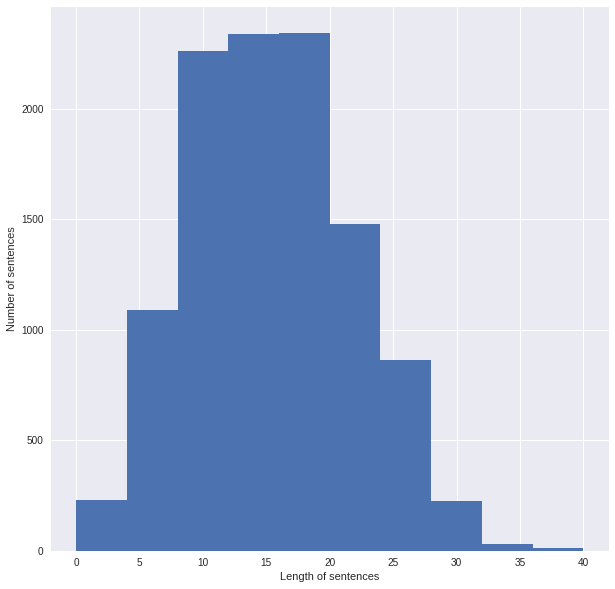

Average length of a sentence: 14.978484737035675


In [13]:
def plot_the_length_of_sentences():
  file = pd.read_csv('clean_data.csv', encoding = 'latin-1')
  tweets = file['text']
  sentences_length = []
  for line in tweets:
    words = word_tokenize(line)
    sentences_length.append(len(words))
    
  fig = plt.figure(figsize = (10, 10))
  plt.xlabel('Length of sentences')
  plt.ylabel('Number of sentences')
  plt.hist(sentences_length, range = (0,40))
  plt.show()
  
  return sentences_length

  
sentences_length = plot_the_length_of_sentences()
print('Average length of a sentence:', sum(sentences_length)/len(questions['text']))

In [0]:
word_embeddings = []
word_embeddings_word = []
i = 0
with open('glove.6B.100d.txt', 'r') as f:
  lines = f.readlines()
  len_ = len(lines)
  for line in lines[:int(.9*len_)]:         #as it crashes when used whole length
    line = line.lower()
    words = word_tokenize(line)
    word_embeddings_word.append(words[0])
    word_embeddings.append(words[1:])
print(word_embeddings)

In [15]:
print(len(word_embeddings_word))
index_of_a_word_in_lexicon_in_word_embeddings = []
value = []
for word in lexicon:
  if word in word_embeddings_word:
    value.append(word)
    index_in_word_embeddings = word_embeddings_word.index(word)
    index_of_a_word_in_lexicon_in_word_embeddings.append(index_in_word_embeddings)
  else:
    index_of_a_word_in_lexicon_in_word_embeddings.append(0)
    

360000


In [0]:
from sklearn.model_selection import train_test_split

clean_questions = pd.read_csv('clean_data.csv', encoding = 'latin-1') 

outputs = []

for output in clean_questions['choose_one']:
  if output == 'Relevant':
    outputs.append(1)
  elif output == 'Not Relevant':
    outputs.append(0)
  else:
    outputs.append(2)
    
clean_questions['choose_one'] = outputs

list_corpus = clean_questions["text"].tolist()
list_labels = clean_questions["choose_one"].tolist()


X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.1, 
                                                                                random_state=40, shuffle = True)

In [0]:
y_train_dual = []
y_test_dual = []
for i in y_train:
  if i == 1:
    y_train_dual.append([1, 0])
  elif i == 0:
    y_train_dual.append([0, 1])
  else:
    y_train_dual.append([0, 0])
    
for i in y_test:
  if i == 1:
    y_test_dual.append([1, 0])
  elif i == 0:
    y_test_dual.append([0, 1])
  else:
    y_test_dual.append([0, 0])
    
y_train = y_train_dual
y_test = y_test_dual

print(y_train)

In [0]:
def padding_process(lines):
  
  lengths = [len(line) for line in lines]
  
  max_len = max(lengths)

  padded_lines = pad_sequences(lines, maxlen = max_len, dtype = 'str', padding = 'post', truncating = 'post')
  
  return padded_lines, lengths

In [0]:
def convert_to_list(lines):
  list_of_eg = []
  for line in lines:
    line = str(line)
    line= line.lower()
    words = word_tokenize(line)
    '''
    new_words = []
    for word in words:
      if word in value:
        new_words.append(word)
    '''
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    list_of_eg.append(lemmatized_words)
  return list_of_eg

In [0]:
# 2 to 95 because there are faults in the embeddings
def convert_to_vector(lines, max_len):
  no_of_samples = len(lines)
  features_of_batch = []
  for line in lines:
    features_of_line = []
    for word in line:
      feature = np.zeros(93)
      if word in value:
        index_in_lexicon = lexicon.index(word)
        feature = word_embeddings[index_of_a_word_in_lexicon_in_word_embeddings[index_in_lexicon]][3:96]
      features_of_line.append(feature)
    features_of_batch.append(list(features_of_line))
  features_of_batch = np.array(features_of_batch)
  features_of_batch = np.reshape(features_of_batch, (no_of_samples, max_len, 93))
  print(features_of_batch.shape)
    
  return features_of_batch

features = convert_to_list(X_train[:128])
features, lengths = padding_process(features)
features = convert_to_vector(features, max(lengths))

print(features[1])            
              


In [0]:
os.chdir('/content')
!git clone https://github.com/mixuala/colab_utils
import colab_utils.tboard
ROOT = %pwd
print(ROOT)
LOG_DIR = os.path.join(ROOT, 'gaurav')
print(LOG_DIR)
colab_utils.tboard.launch_tensorboard( bin_dir=ROOT, log_dir=LOG_DIR )

In [0]:
from tensorflow.python.ops import rnn, rnn_cell
tf.reset_default_graph()

In [0]:
batch_size = 128
rnn_size = 12
len_of_word_embedding_vector = 93
output_nodes = 2


x = tf.placeholder('float', name = 'input_labels', shape = [None, None, 93])
y = tf.placeholder('float', name = 'output_labels')
dropout_prob = tf.placeholder('float', name = 'keep_prob')
input_sequence_length = tf.placeholder(dtype = tf.int32, shape = [None], name = 'input_sequence_length')
max_len = tf.placeholder(dtype = tf.int32)


hm_epochs = 30
output_layer = {'weights': tf.Variable(tf.random_normal([rnn_size*2, output_nodes], name = 'weights')),
                'biases' : tf.Variable(tf.random_normal([1, output_nodes], name = 'biases'))}

In [0]:
def neural_network_model(x, input_sequence_length, max_len, keep_prob):
  with tf.name_scope('neural_network'):
    forward_cell = tf.nn.rnn_cell.BasicLSTMCell(rnn_size)
    backward_cell = tf.nn.rnn_cell.BasicLSTMCell(rnn_size)
    forward_drop = tf.contrib.rnn.DropoutWrapper(forward_cell, input_keep_prob = keep_prob)
    backward_drop = tf.contrib.rnn.DropoutWrapper(backward_cell, input_keep_prob = keep_prob)
    x = tf.transpose(x, [1,0,2])
    bi_outputs, encoder_state = tf.nn.bidirectional_dynamic_rnn(forward_drop, backward_drop, x, dtype = tf.float32,
                                                              sequence_length = input_sequence_length, time_major=True)
    output = tf.concat(encoder_state, -1)
    '''

    x = tf.reshape(x, [-1, chunk_size])
    x = tf.split(x, n_chunks, 0)
    output, states = rnn.static_rnn(forward_cell,x ,dtype=tf.float32)
    '''
    outputs = tf.matmul(output[0],output_layer['weights']) + output_layer['biases']
    
    return outputs

In [0]:
def train_neural_network(x):
  #beta = 0.00001
  prediction = neural_network_model(x, input_sequence_length, max_len, dropout_prob)
  #regularizer = tf.nn.l2_loss(output_layer['weights'])
  with tf.name_scope('cost'):  
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = prediction, labels = y))
  summary = tf.summary.scalar('t', cost)
  
  with tf.name_scope('Optimizer'):
    optimizer = tf.train.AdamOptimizer(learning_rate = 0.01).minimize(cost)
    
  merged = tf.summary.merge_all() 
  
  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer()) 
    train_writer = tf.summary.FileWriter('./gaurav',sess.graph)
    k = 0
    len_of_train_data = len(X_train)
    for epoch in range(hm_epochs):
      epoch_loss = 0
      starting = 0
      end = batch_size
   
      while end <= len_of_train_data:
        epoch_x = X_train[starting:end]
        epoch_y = y_train[starting:end]
        starting = end
        end = end + batch_size
        epoch_x = convert_to_list(epoch_x)
        new_epoch_x = []
        new_epoch_y = []
        i = 0
        for line in epoch_x:
          if len(line) < 20:
            new_epoch_x.append(line)
            new_epoch_y.append(epoch_y[i])
          i = i + 1
        epoch_x, lengths = padding_process(new_epoch_x)
        epoch_x = convert_to_vector(epoch_x, max(lengths))
        epoch_y = new_epoch_y
        _, c, m = sess.run([optimizer, cost, merged], feed_dict={x: epoch_x, y: epoch_y, max_len : max(lengths),
                                                                 input_sequence_length:lengths,dropout_prob : 0.7,
                                                                 learning : 8.0/(1000 + 80*epoch)})
        
        epoch_loss += c
        train_writer.add_summary(m, k)
        k += 1
      
      print('loss after ', epoch, 'is', epoch_loss)
            
      correct = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))

      accuracy = tf.reduce_mean(tf.cast(correct, 'float'))

      epoch_y = y_test
      epoch_x = X_test
      epoch_x = convert_to_list(epoch_x)
      new_epoch_x = []
      new_epoch_y = []
      i = 0
      for line in epoch_x:
        if len(line) < 20:
          new_epoch_x.append(line)
          new_epoch_y.append(epoch_y[i])
        i = i + 1
      epoch_x, lengths = padding_process(new_epoch_x)
      epoch_x = convert_to_vector(epoch_x, max(lengths))

      epoch_y = new_epoch_y
    
    
      print('Accuracy:',accuracy.eval({x:epoch_x, y:epoch_y, dropout_prob : 1.0, input_sequence_length:lengths, max_len : max(lengths) }))
      
    correct = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))

    accuracy = tf.reduce_mean(tf.cast(correct, 'float'))
    
    epoch_y = y_test
    epoch_x = X_test
    epoch_x = convert_to_list(epoch_x)
    new_epoch_x = []
    new_epoch_y = []
    i = 0
    for line in epoch_x:
      if len(line) < 10:
        new_epoch_x.append(line)
        new_epoch_y.append(epoch_y[i])
      i = i + 1
    epoch_x, lengths = padding_process(new_epoch_x)
    epoch_x = convert_to_vector(epoch_x, max(lengths))
    
    epoch_y = new_epoch_y
    
    
    print('Accuracy:',accuracy.eval({x:epoch_x, y:epoch_y, dropout_prob : 1.0, input_sequence_length:lengths, max_len : max(lengths) }))
    
train_neural_network(x)